# Trabajo Práctico 4

# Imports y función de entrenamiento

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import copy
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [3]:
def entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(clf) == KNeighborsRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss
    best_clf = None
    best_error = 1.0
    train_errors = []
    val_errors = []
    test_errors = []
    for k in range(max_k):
        clf.n_neighbors = k+1
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_train)
        train_error = error_fun(y_train, y_pred)

        y_pred = clf.predict(X_val)
        val_error = error_fun(y_val, y_pred)

        y_pred = clf.predict(X_test)
        test_error = error_fun(y_test, y_pred)

        train_errors.append(train_error)
        val_errors.append(val_error)
        test_errors.append(test_error)
        if val_error < best_error:
            best_clf = copy.deepcopy(clf)
            best_error = val_error
    return best_clf, train_errors, val_errors, test_errors

In [4]:
def entrenar_red_weight_decay(red, evaluaciones, X_train, y_train, X_test, y_test, weight_fun = np.square):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      weight_sum.append(np.sum([np.sum(weight_fun(w)) for w in red.coefs_]))

    return red, error_train, error_test, weight_sum

In [5]:
def cargar_csv(path, xcols=2, delim_whitespace=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

In [6]:
def covM(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1]*d, covM(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1]*d, covM(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

def covM2(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1] + [0]*(d-1), covM2(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1] + [0]*(d-1), covM2(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

In [15]:
def avg_errors(error_dict, count_for_avg = 20):
  errors_test = []
  errors_train = []
  for k, l in error_dict.items():
    sum_train = 0
    sum_test = 0
    for e in l:
      sum_train += e['error_train']
      sum_test += e['error_test']
    errors_test.append(sum_test/count_for_avg)
    errors_train.append(sum_train/count_for_avg)
  return errors_train, errors_test

# Ejercicio A

## Espirales originales

In [32]:
X_data, y_data = cargar_csv("./data/espirales_con_ruido/c_0.data", 2)
X_test, y_test = cargar_csv("./data/espirales_con_ruido/c_0.test", 2)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_21296\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_21296\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


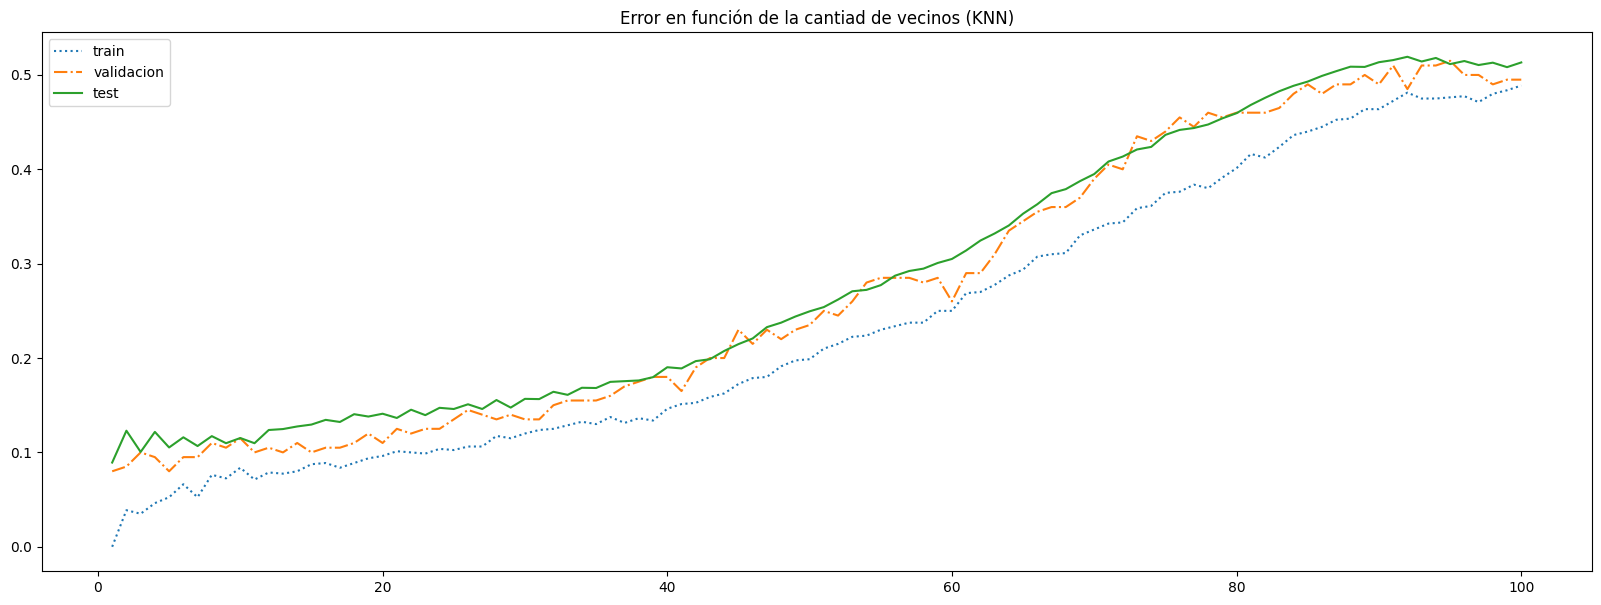

In [33]:
# KNN
max_k = 100
clf = KNeighborsClassifier()
best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_KNN, label="train", linestyle=":")
plt.plot(rango, val_errors_KNN, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_KNN, label="test", linestyle="-")
plt.title(f'Error en función de la cantiad de vecinos (KNN)')
plt.legend()
plt.show()

In [38]:
print(f"Mejor cantidad de vecinos: {best_clf_KNN.n_neighbors}")
print(f"Error en conjunto de entrenamiento: {train_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de validación: {val_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de test: {test_errors_KNN[best_clf_KNN.n_neighbors-1]}")

Mejor cantidad de vecinos: 1
Error en conjunto de entrenamiento: 0.0
Error en conjunto de validación: 0.07999999999999996
Error en conjunto de test: 0.08925000000000005


In [39]:
t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
t.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.002,
                       min_samples_leaf=5, random_state=0)

In [40]:
print(f"Error de arbol en conjunto de entrenamiento: {zero_one_loss(y_train, t.predict(X_train))}")
print(f"Error de arbol en conjunto de validación: {zero_one_loss(y_val, t.predict(X_val))}")
print(f"Error de arbol en conjunto de test: {zero_one_loss(y_test, t.predict(X_test))}")

Error de arbol en conjunto de entrenamiento: 0.07499999999999996
Error de arbol en conjunto de validación: 0.09499999999999997
Error de arbol en conjunto de test: 0.15025


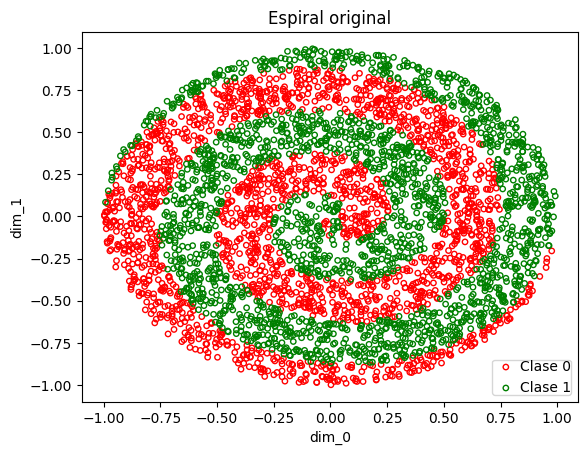

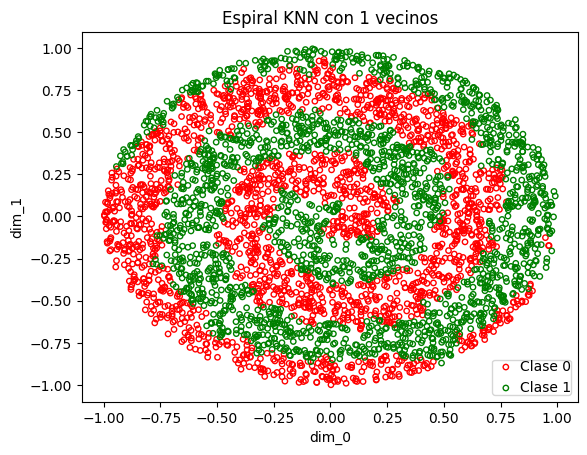

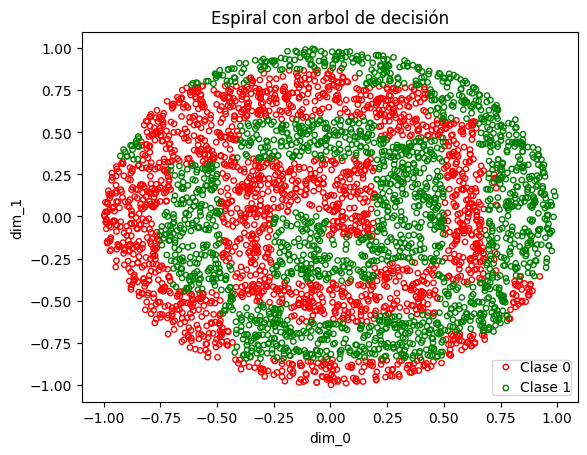

In [42]:
idx = np.where(y_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral original')
plt.show()

P_test = best_clf_KNN.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral KNN con {best_clf_KNN.n_neighbors} vecinos')
plt.show()

P_test = t.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test.to_numpy()[idx, 0],
    X_test.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral con arbol de decisión')
plt.show()

## Espirales con ruido

In [45]:
X_data, y_data = cargar_csv("./data/espirales_con_ruido/c_2.data", 4)
X_test, y_test = cargar_csv("./data/espirales_con_ruido/c_2.test", 4)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_21296\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_21296\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


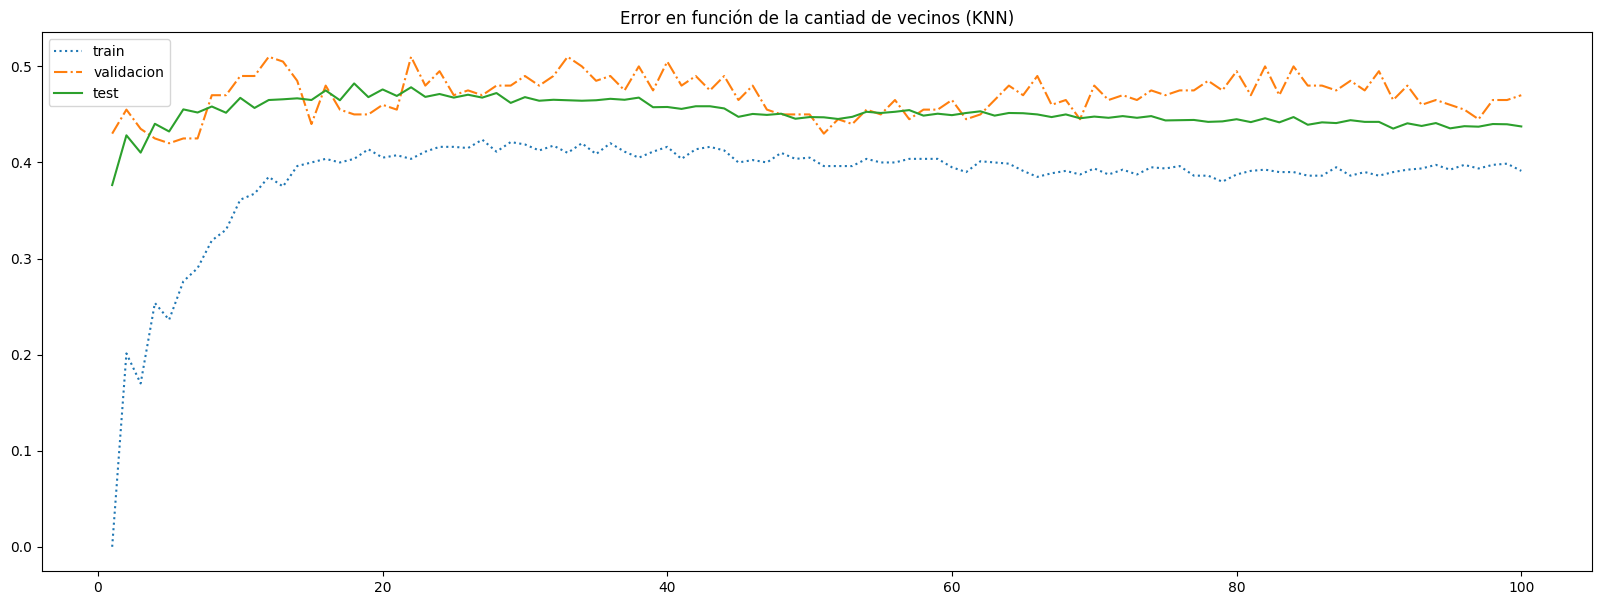

In [46]:
# KNN
max_k = 100
clf = KNeighborsClassifier()
best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train, y_train, X_val, y_val, X_test, y_test)

rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_KNN, label="train", linestyle=":")
plt.plot(rango, val_errors_KNN, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_KNN, label="test", linestyle="-")
plt.title(f'Error en función de la cantiad de vecinos (KNN)')
plt.legend()
plt.show()

In [47]:
print(f"Mejor cantidad de vecinos: {best_clf_KNN.n_neighbors}")
print(f"Error en conjunto de entrenamiento: {train_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de validación: {val_errors_KNN[best_clf_KNN.n_neighbors-1]}")
print(f"Error en conjunto de test: {test_errors_KNN[best_clf_KNN.n_neighbors-1]}")

Mejor cantidad de vecinos: 5
Error en conjunto de entrenamiento: 0.23624999999999996
Error en conjunto de validación: 0.42000000000000004
Error en conjunto de test: 0.43225


In [48]:
t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
t.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.002,
                       min_samples_leaf=5, random_state=0)

In [49]:
print(f"Error de arbol en conjunto de entrenamiento: {zero_one_loss(y_train, t.predict(X_train))}")
print(f"Error de arbol en conjunto de validación: {zero_one_loss(y_val, t.predict(X_val))}")
print(f"Error de arbol en conjunto de test: {zero_one_loss(y_test, t.predict(X_test))}")

Error de arbol en conjunto de entrenamiento: 0.06999999999999995
Error de arbol en conjunto de validación: 0.20999999999999996
Error de arbol en conjunto de test: 0.19525000000000003


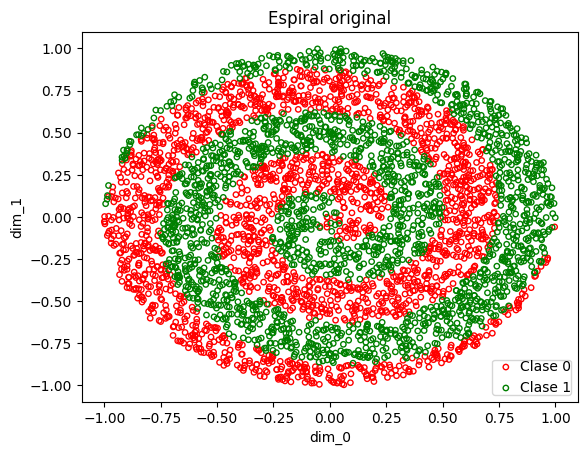

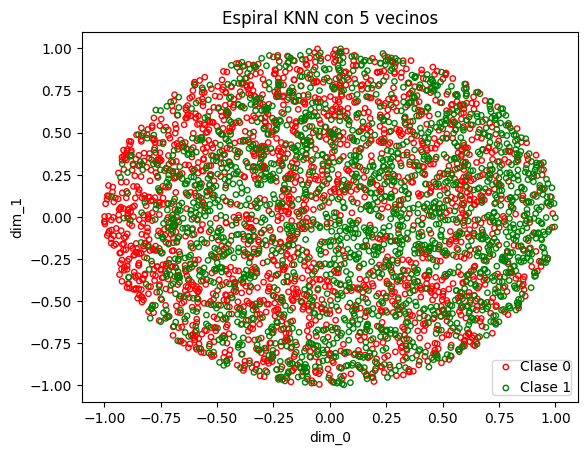

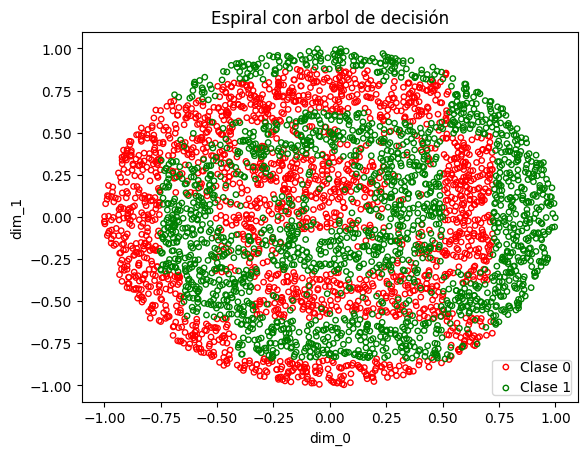

In [50]:
X_test_2_dims = X_test.iloc[:, 0:2]

idx = np.where(y_test == 0)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)

idx = np.where(y_test == 1)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral original')
plt.show()

P_test = best_clf_KNN.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral KNN con {best_clf_KNN.n_neighbors} vecinos')
plt.show()

P_test = t.predict(X_test)

idx = np.where(P_test == 0)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='r',
    label="Clase 0",
    cmap=plt.cm.RdYlBu,
    s=15,
)
idx = np.where(P_test == 1)
plt.scatter(
    X_test_2_dims.to_numpy()[idx, 0],
    X_test_2_dims.to_numpy()[idx, 1],
    facecolors='none',
    edgecolors='g',
    label="Clase 1",
    cmap=plt.cm.RdYlBu,
    s=15,
)

plt.xlabel("dim_0")
plt.ylabel("dim_1")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.title(f'Espiral con arbol de decisión')
plt.show()

## Análisis

# Ejercicio B

In [57]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
gamma = 0.0001
N2 = 6

## Diagonales

In [58]:
errors_diagonales_trees = {}
errors_diagonales_redes = {}
errors_diagonales_naive_bayes = {}
errors_diagonales_knn_1 = {}
errors_diagonales_knn_best = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []
  errors_list_knn_1 = []
  errors_list_knn_best = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # KNN
    max_k = 100
    clf = KNeighborsClassifier()
    X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
    best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

  errors_diagonales_redes[d] = errors_list_redes
  errors_diagonales_trees[d] = errors_list_trees
  errors_diagonales_naive_bayes[d] = errors_list_naive_bayes
  errors_diagonales_knn_1[d] = errors_list_knn_1
  errors_diagonales_knn_best[d] = errors_list_knn_best

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [60]:
errors_train_diagonales_tree_avg, errors_test_diagonales_tree_avg = avg_errors(errors_diagonales_trees)
errors_train_diagonales_red_avg, errors_test_diagonales_red_avg = avg_errors(errors_diagonales_redes)
errors_train_diagonales_naive_bayes_avg, errors_test_diagonales_naive_bayes_avg = avg_errors(errors_diagonales_naive_bayes)
errors_train_diagonales_knn_1_avg, errors_test_diagonales_knn_1_avg = avg_errors(errors_diagonales_knn_1)
errors_train_diagonales_knn_best_avg, errors_test_diagonales_knn_best_avg = avg_errors(errors_diagonales_knn_best)

## Paralelas

In [61]:
errors_paralelas_redes = {}
errors_paralelas_trees = {}
errors_paralelas_naive_bayes = {}
errors_paralelas_knn_1 = {}
errors_paralelas_knn_best = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []
  errors_list_knn_1 = []
  errors_list_knn_best = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # KNN
    max_k = 100
    clf = KNeighborsClassifier()
    X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
    best_clf_KNN, train_errors_KNN, val_errors_KNN, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
  
  errors_paralelas_redes[d] = errors_list_redes
  errors_paralelas_trees[d] = errors_list_trees
  errors_paralelas_naive_bayes[d] = errors_list_naive_bayes
  errors_paralelas_knn_1[d] = errors_list_knn_1
  errors_paralelas_knn_best[d] = errors_list_knn_best

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [16]:
errors_train_paralelas_tree_avg, errors_test_paralelas_tree_avg = avg_errors(errors_paralelas_trees)
errors_train_paralelas_red_avg, errors_test_paralelas_red_avg = avg_errors(errors_paralelas_redes)
errors_train_paralelas_naive_bayes_avg, errors_test_paralelas_naive_bayes_avg = avg_errors(errors_paralelas_naive_bayes)
errors_train_paralelas_knn_1_avg, errors_test_paralelas_knn_1_avg = avg_errors(errors_paralelas_knn_1)
errors_train_paralelas_knn_best_avg, errors_test_paralelas_knn_best_avg = avg_errors(errors_paralelas_knn_best)

NameError: name 'errors_paralelas_trees' is not defined

## Gráficas

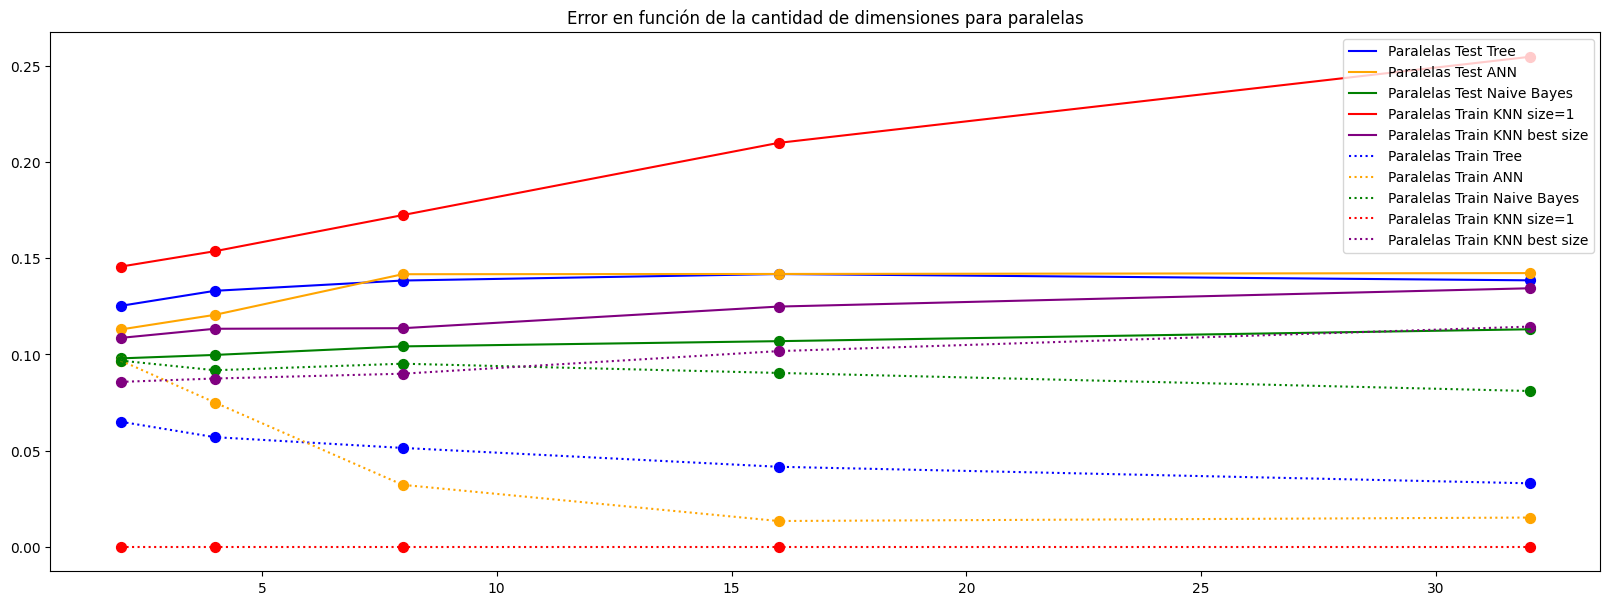

In [73]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle="-", color='red')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle="-", color='purple')

plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='red')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='purple')

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

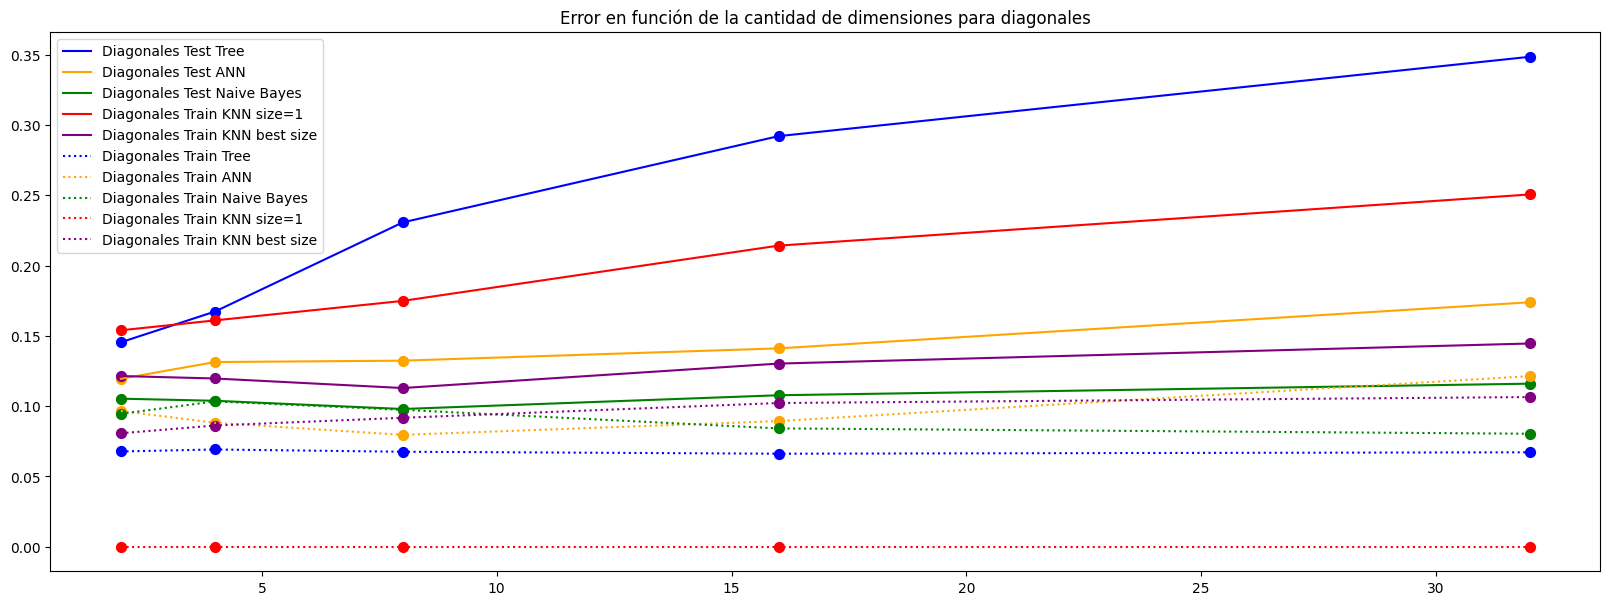

In [74]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle="-", color='blue')
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-", color='orange')
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle="-", color='green')
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-", color='red')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-", color='purple')

plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle=":", color='blue')
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle=":", color='orange')
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Diagonales Train Naive Bayes", linestyle=":", color='green')
plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle=":", color='red')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle=":", color='purple')

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para diagonales')
plt.legend()
plt.show()


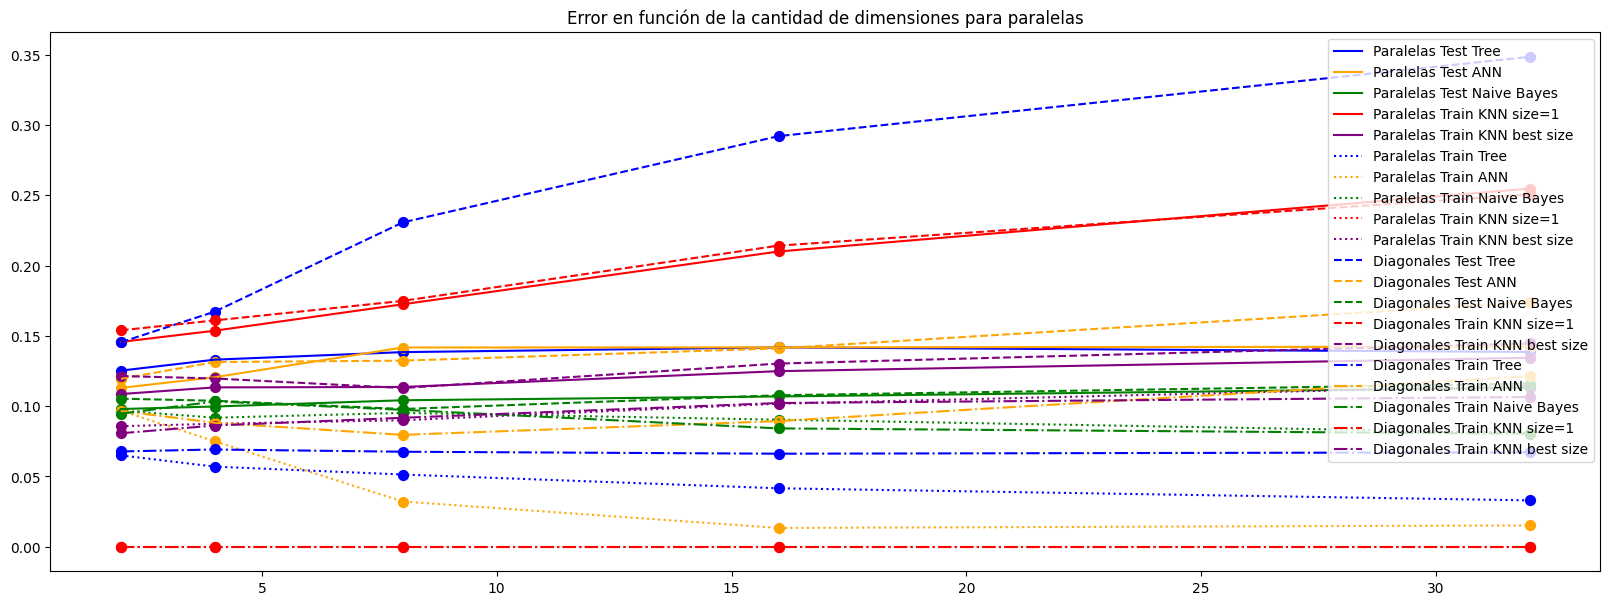

: 

In [78]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle="-", color='red')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle="-", color='purple')

plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='red')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='purple')

plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle="--", color='blue')
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="--", color='orange')
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle="--", color='green')
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="--", color='red')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="--", color='purple')

plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-.", color='blue')
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="-.", color='orange')
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Diagonales Train Naive Bayes", linestyle="-.", color='green')
plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-.", color='red')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-.", color='purple')


plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.scatter(d_values, errors_train_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='purple', s=50) # puntos en violeta

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

## Análisis

# Ejercicio C

In [42]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20
k_fijo = 50
max_k = 200

## Diagonales

Primero genero los errores para 32 dimensiones

In [39]:
d = 32
df_test = diagonales(n_testing, d, C)
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

df_train = diagonales(n_training, d, C)
y_train = df_train["class"].to_numpy()
X_train = df_train.drop(columns=["class"]).to_numpy()
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
clf = KNeighborsClassifier(weights='distance')
_, train_errors_diagonales_32, val_errors_diagonales_32, test_errors_diagonales_32 = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

Luego hago los promedios de ambos clasificadores en todas las dimensiones

In [43]:
errors_diagonales_knn_1 = {}
errors_diagonales_knn_best = {}
errors_diagonales_knn_weighted_fijo = {}
errors_diagonales_knn_weighted_best = {}

for d in d_values:
  errors_list_knn_1 = []
  errors_list_knn_best = []
  errors_list_knn_weighted_fijo = []
  errors_list_knn_weighted_best = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # KNN
    clf = KNeighborsClassifier()
    X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
    _, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

    # KNN weighted
    clf = KNeighborsClassifier(weights='distance')
    _, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_weighted_fijo.append({'error_test': test_errors_KNN[k_fijo-1], 'error_train': train_errors_KNN[k_fijo-1]})
    errors_list_knn_weighted_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

  errors_diagonales_knn_1[d] = errors_list_knn_1
  errors_diagonales_knn_best[d] = errors_list_knn_best
  errors_diagonales_knn_weighted_fijo[d] = errors_list_knn_weighted_fijo
  errors_diagonales_knn_weighted_best[d] = errors_list_knn_weighted_best

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


In [47]:
errors_train_diagonales_knn_1_avg, errors_test_diagonales_knn_1_avg = avg_errors(errors_diagonales_knn_1)
errors_train_diagonales_knn_best_avg, errors_test_diagonales_knn_best_avg = avg_errors(errors_diagonales_knn_best)
errors_train_diagonales_knn_weighted_fijo_avg, errors_test_diagonales_knn_weighted_fijo_avg = avg_errors(errors_diagonales_knn_weighted_fijo)
errors_train_diagonales_knn_weighted_best_avg, errors_test_diagonales_knn_weighted_best_avg = avg_errors(errors_diagonales_knn_weighted_best)

## Paralelas

Primero genero los errores para 32 dimensiones

In [40]:
d = 32
df_test = paralelas(n_testing, d, C)
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

df_train = paralelas(n_training, d, C)
y_train = df_train["class"].to_numpy()
X_train = df_train.drop(columns=["class"]).to_numpy()
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
clf = KNeighborsClassifier(weights='distance')
_, train_errors_paralelas_32, val_errors_paralelas_32, test_errors_paralelas_32 = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

Luego hago los promedios de ambos clasificadores en todas las dimensiones

In [44]:
errors_paralelas_knn_1 = {}
errors_paralelas_knn_best = {}
errors_paralelas_knn_weighted_fijo = {}
errors_paralelas_knn_weighted_best = {}

for d in d_values:
  errors_list_knn_1 = []
  errors_list_knn_best = []
  errors_list_knn_weighted_fijo = []
  errors_list_knn_weighted_best = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # KNN
    clf = KNeighborsClassifier()
    X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train, y_train, test_size = 0.2)
    _, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_1.append({'error_test': test_errors_KNN[0], 'error_train': train_errors_KNN[0]})
    errors_list_knn_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})
  
    # KNN weighted
    clf = KNeighborsClassifier(weights='distance')
    _, train_errors_KNN, _, test_errors_KNN = entrenar_KNN(clf, max_k, X_train_2, y_train_2, X_val_2, y_val_2, X_test, y_test)

    errors_list_knn_weighted_fijo.append({'error_test': test_errors_KNN[k_fijo-1], 'error_train': train_errors_KNN[k_fijo-1]})
    errors_list_knn_weighted_best.append({'error_test': test_errors_KNN[best_clf_KNN.n_neighbors-1], 'error_train': train_errors_KNN[best_clf_KNN.n_neighbors-1]})

  errors_paralelas_knn_1[d] = errors_list_knn_1
  errors_paralelas_knn_best[d] = errors_list_knn_best
  errors_paralelas_knn_weighted_fijo[d] = errors_list_knn_weighted_fijo
  errors_paralelas_knn_weighted_best[d] = errors_list_knn_weighted_best

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [48]:
errors_train_paralelas_knn_1_avg, errors_test_paralelas_knn_1_avg = avg_errors(errors_paralelas_knn_1)
errors_train_paralelas_knn_best_avg, errors_test_paralelas_knn_best_avg = avg_errors(errors_paralelas_knn_best)
errors_train_paralelas_knn_weighted_fijo_avg, errors_test_paralelas_knn_weighted_fijo_avg = avg_errors(errors_paralelas_knn_weighted_fijo)
errors_train_paralelas_knn_weighted_best_avg, errors_test_paralelas_knn_weighted_best_avg = avg_errors(errors_paralelas_knn_weighted_best)

## Gráficas

### 32 dimensiones

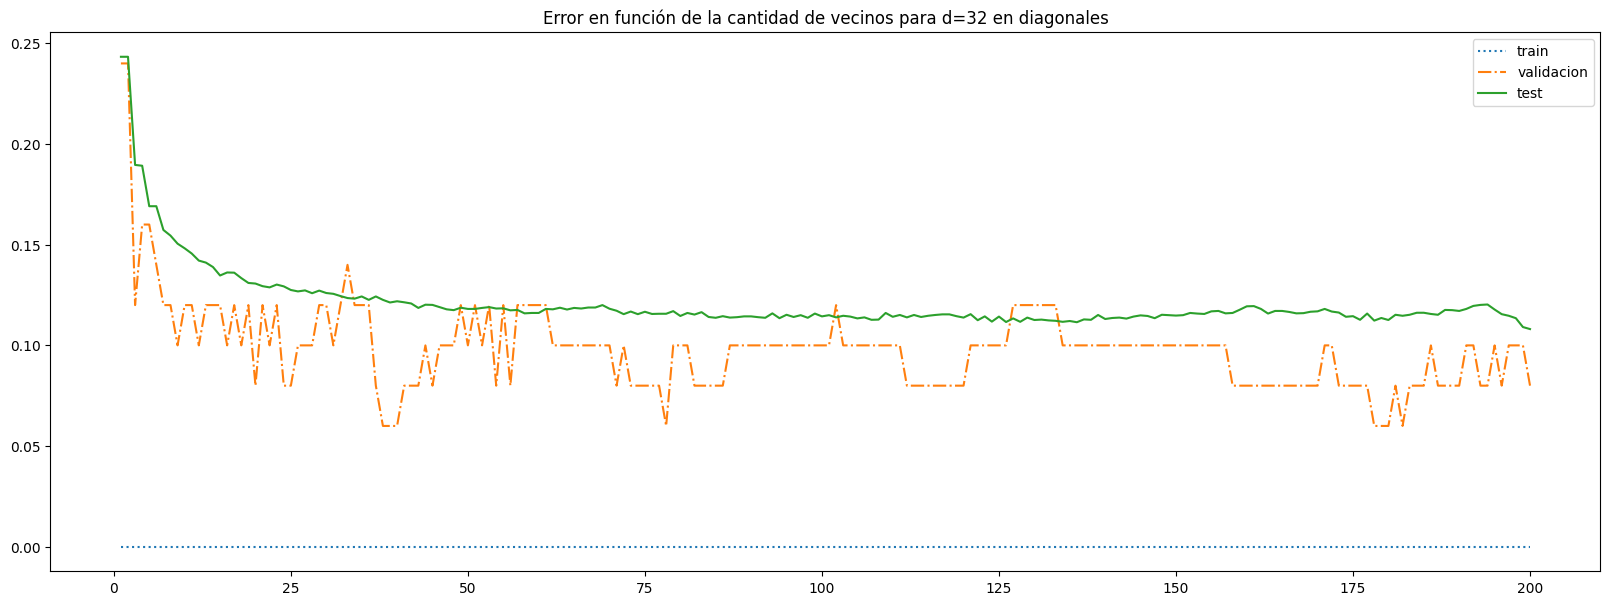

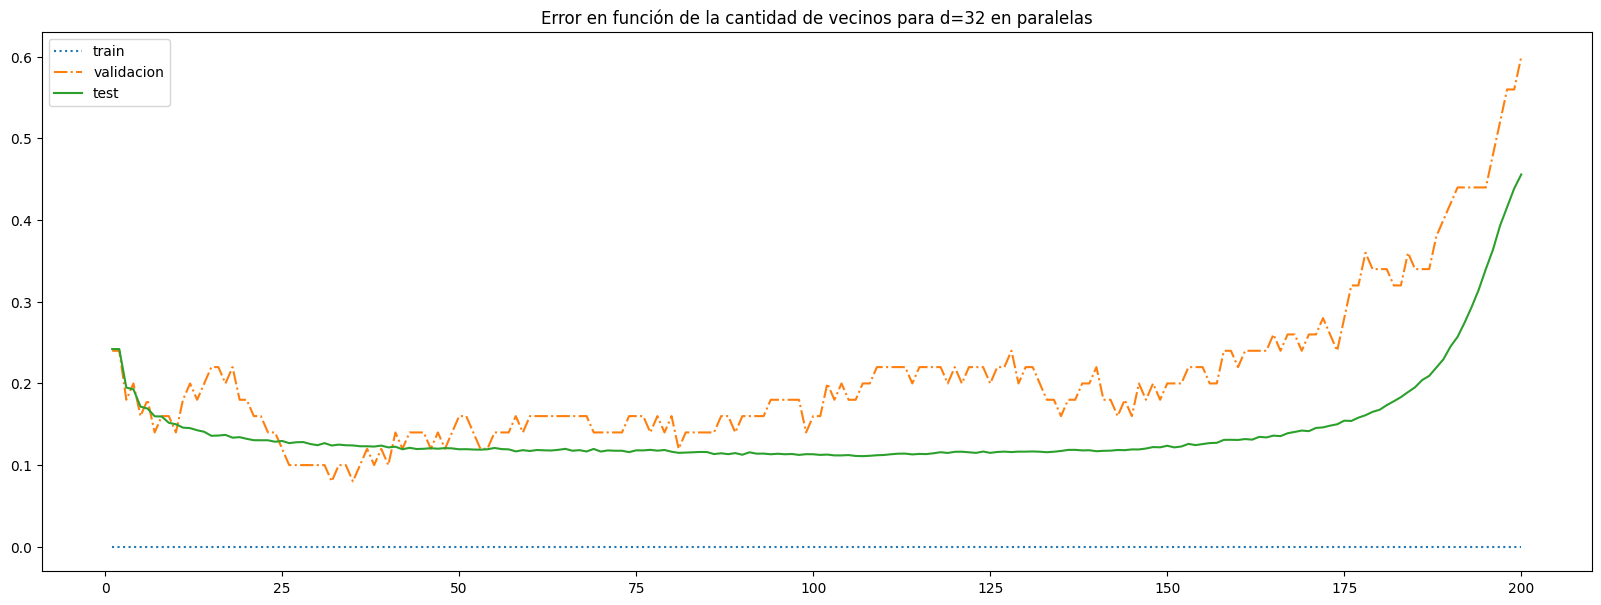

In [41]:
rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_diagonales_32, label="train", linestyle=":")
plt.plot(rango, val_errors_diagonales_32, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_diagonales_32, label="test", linestyle="-")
plt.title(f'Error en función de la cantidad de vecinos para d=32 en diagonales')
plt.legend()
plt.show()

rango = range(1, max_k+1)
plt.figure(figsize=(20, 7))
plt.plot(rango, train_errors_paralelas_32, label="train", linestyle=":")
plt.plot(rango, val_errors_paralelas_32, label="validacion", linestyle="-.")
plt.plot(rango, test_errors_paralelas_32, label="test", linestyle="-")
plt.title(f'Error en función de la cantidad de vecinos para d=32 en paralelas')
plt.legend()
plt.show()

### Errores por dimensión

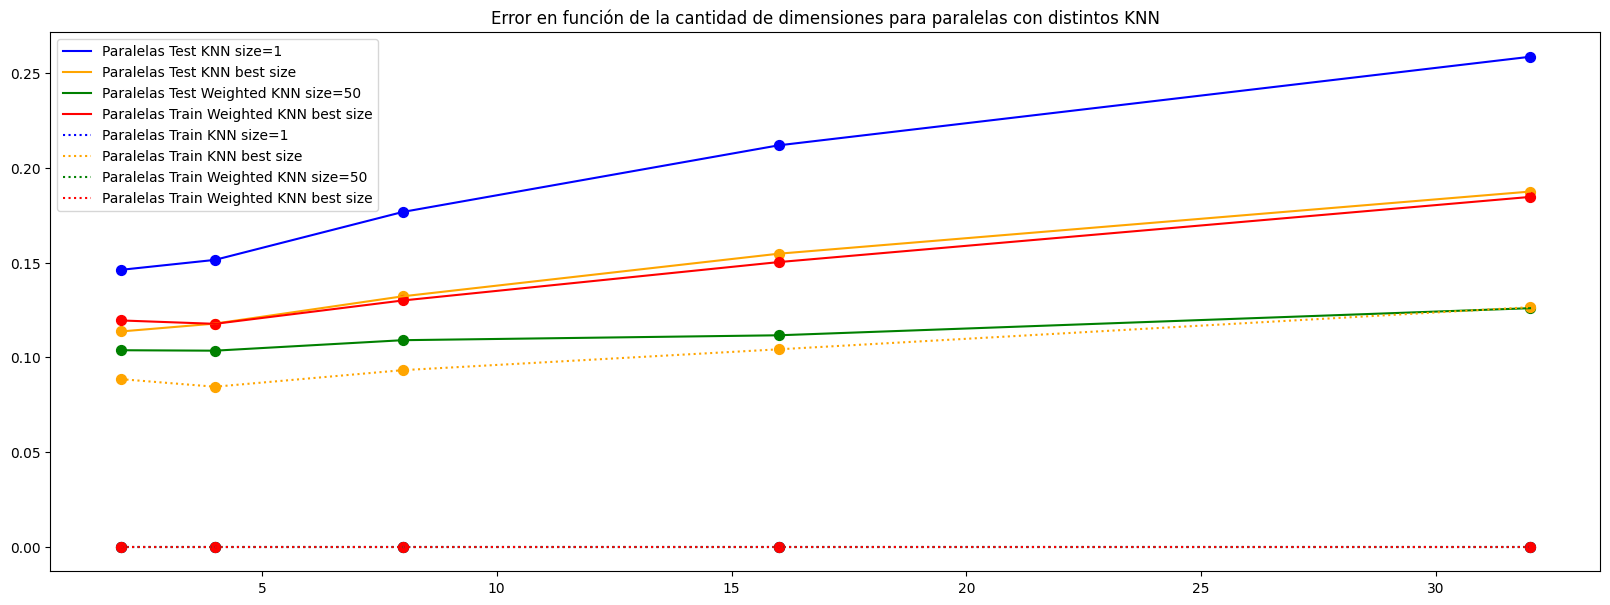

In [49]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_weighted_fijo_avg, label="Paralelas Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle="-", color='red')

plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_weighted_fijo_avg, label="Paralelas Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle=":", color='red')

plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.title(f'Error en función de la cantidad de dimensiones para paralelas con distintos KNN')
plt.legend()
plt.show()

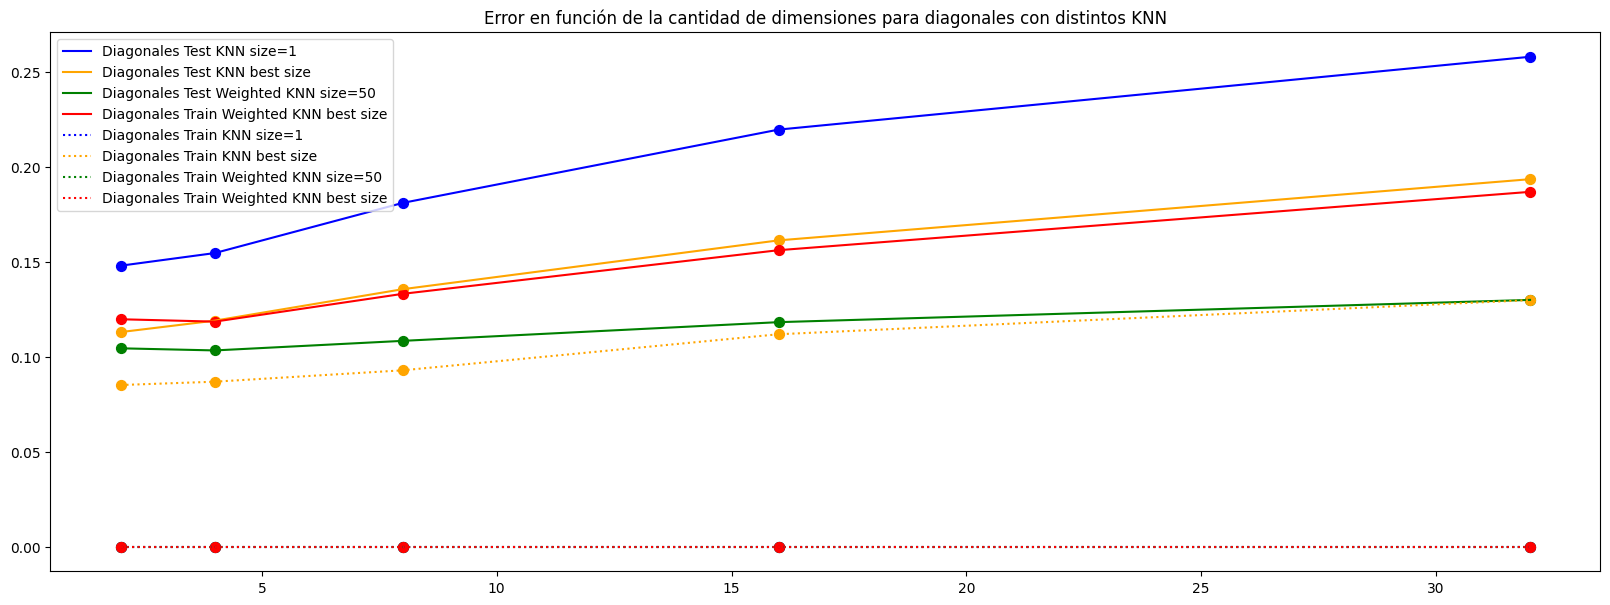

In [50]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_weighted_fijo_avg, label="Diagonales Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="-", color='red')

plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_weighted_fijo_avg, label="Diagonales Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle=":", color='red')

plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.title(f'Error en función de la cantidad de dimensiones para diagonales con distintos KNN')
plt.legend()
plt.show()

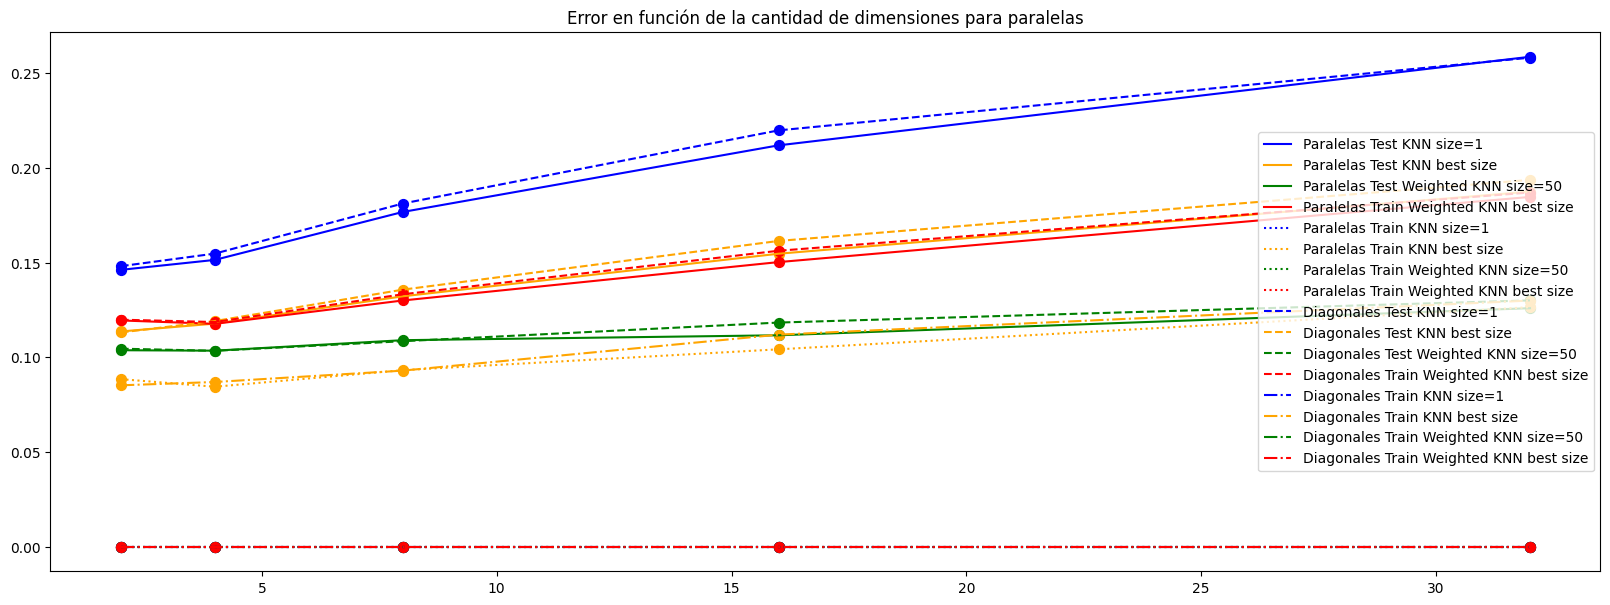

In [51]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_knn_1_avg, label="Paralelas Test KNN size=1", linestyle="-", color='blue')
plt.plot(d_values, errors_test_paralelas_knn_best_avg, label="Paralelas Test KNN best size", linestyle="-", color='orange')
plt.plot(d_values, errors_test_paralelas_knn_weighted_fijo_avg, label="Paralelas Test Weighted KNN size=50", linestyle="-", color='green')
plt.plot(d_values, errors_test_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle="-", color='red')

plt.plot(d_values, errors_train_paralelas_knn_1_avg, label="Paralelas Train KNN size=1", linestyle=":", color='blue')
plt.plot(d_values, errors_train_paralelas_knn_best_avg, label="Paralelas Train KNN best size", linestyle=":", color='orange')
plt.plot(d_values, errors_train_paralelas_knn_weighted_fijo_avg, label="Paralelas Train Weighted KNN size=50", linestyle=":", color='green')
plt.plot(d_values, errors_train_paralelas_knn_weighted_best_avg, label="Paralelas Train Weighted KNN best size", linestyle=":", color='red')

plt.plot(d_values, errors_test_diagonales_knn_1_avg, label="Diagonales Test KNN size=1", linestyle="--", color='blue')
plt.plot(d_values, errors_test_diagonales_knn_best_avg, label="Diagonales Test KNN best size", linestyle="--", color='orange')
plt.plot(d_values, errors_test_diagonales_knn_weighted_fijo_avg, label="Diagonales Test Weighted KNN size=50", linestyle="--", color='green')
plt.plot(d_values, errors_test_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="--", color='red')

plt.plot(d_values, errors_train_diagonales_knn_1_avg, label="Diagonales Train KNN size=1", linestyle="-.", color='blue')
plt.plot(d_values, errors_train_diagonales_knn_best_avg, label="Diagonales Train KNN best size", linestyle="-.", color='orange')
plt.plot(d_values, errors_train_diagonales_knn_weighted_fijo_avg, label="Diagonales Train Weighted KNN size=50", linestyle="-.", color='green')
plt.plot(d_values, errors_train_diagonales_knn_weighted_best_avg, label="Diagonales Train Weighted KNN best size", linestyle="-.", color='red')

plt.scatter(d_values, errors_test_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_paralelas_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_paralelas_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_paralelas_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_test_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_test_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo

plt.scatter(d_values, errors_train_diagonales_knn_1_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_train_diagonales_knn_best_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_train_diagonales_knn_weighted_fijo_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_knn_weighted_best_avg, color='red', s=50)  # puntos en rojo


plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

## Análisis

# Ejercicio D

# Ejercicio E

# Ejercicio F